In [7]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import os.path
import json
import pickle
import h5py
import sys
import F1F0

from var_utils import *

save_result_dir = r"./"
dir_syn = r"./biophysical"
# dir_stp = r"//allen/programs/braintv/workgroups/v1column/binghuangc/network_effect/Column_Simulation/STP_update_syn_tau/run_spike_trains/results/"


# Load the nodes
nodes_DF = pd.read_csv('../Biophysical_network/net/v1_nodes.csv', sep = ' ')
print "Neuron dataframe:"
print nodes_DF.head()

orientations = np.arange(0,360,45)
trials = np.arange(10)
stimulusTypeName = "gratings"
total_n_neurons = 230924
np.random.seed(100)

pop_names_bph = np.array(['e23Cux2', 'e4Rorb', 'e4Nr5a1' , 'e4Scnn1a', 'e4other','e5Rbp4','e5noRbp4', 'e6Ntsr1'
                , 'i23Pvalb', 'i1Htr3a','i23Htr3a','i23Sst', 'i4Pvalb', 'i4Htr3a', 'i4Sst', 'i5Pvalb'
                 , 'i5Sst', 'i5Htr3a', 'i6Pvalb', 'i6Sst', 'i6Htr3a'])

Neuron dataframe:
   id   model_id      x_soma      y_soma      z_soma  rotation_angle_yaxis  \
0   0  100000101  110.906706 -431.668136  623.732700              1.247325   
1   1  100000101  526.329919 -564.693981 -555.341582              3.418240   
2   2  100000101  197.897567 -505.737886  709.692990              0.463397   
3   3  100000101  400.302561 -465.458859 -224.639993              4.102361   
4   4  100000101 -766.751467 -556.178476   55.929619              2.800441   

    pop_name ei location  tuning_angle  
0  LIFe5Rbp4  e    VisL5      0.000000  
1  LIFe5Rbp4  e    VisL5      0.017278  
2  LIFe5Rbp4  e    VisL5      0.034556  
3  LIFe5Rbp4  e    VisL5      0.051833  
4  LIFe5Rbp4  e    VisL5      0.069111  


In [8]:
def bin_resp_spk(spike_data, n_neurons, start_time, end_time, win_size, bin_stride):
    # assumes spike_data DataFrame
    spike_rate = np.zeros((n_neurons,len(range(start_time, end_time, bin_stride))))           
    for l_ind, t_ind in enumerate(range(start_time,end_time, bin_stride)):
        count_loop = spike_data[spike_data["time"]>t_ind][spike_data["time"]<t_ind+win_size].groupby("cell")["time"].count()
        spike_rate[count_loop.index,l_ind] = count_loop
    #print "Done!"
    return spike_rate

def change_bin_win(spike_rate_ephys_1ms, win_size):
    spike_rate_ephys = np.zeros((spike_rate_ephys_1ms.shape[0], np.int(spike_rate_ephys_1ms.shape[1]/win_size)+1, spike_rate_ephys_1ms.shape[2]))
    for bin_ind, bin_edge in enumerate(range(0,spike_rate_ephys_1ms.shape[1],win_size)):
        spike_rate_ephys[:,bin_ind,:] = np.sum(spike_rate_ephys_1ms[:,bin_edge:bin_edge+win_size,:], axis=1)
    return spike_rate_ephys

def get_lifetime_sprs(total_spike_count):
    total_spike_count_trial_averaged = np.nanmean(total_spike_count, axis=2)
    n_conds = total_spike_count_trial_averaged.shape[1]    
    r_data_sq = total_spike_count_trial_averaged**2
    nr = (np.sum(total_spike_count_trial_averaged,1)/n_conds)**2
    dr = (np.sum(r_data_sq,1)/n_conds)
    S = (1 - nr/dr)/(1-(1/n_conds))
#     S=S[~np.isnan(S)]
    return S

def get_pop_sprs(total_spike_count):
    total_spike_count_trial_averaged = np.nanmean(total_spike_count, axis=2)
    n_cells = total_spike_count_trial_averaged.shape[0]    
    r_data_sq = total_spike_count_trial_averaged**2
    nr = (np.sum(total_spike_count_trial_averaged,0)/n_cells)**2
    dr = (np.sum(r_data_sq,0)/n_cells)
    S = (1 - nr/dr)/(1-(1/n_cells))
#     S=S[~np.isnan(S)]
    return S

In [9]:
# parameters for calculation of firing rate over step

end_time = 3000
start_time = 500
win_size = 50
bin_stride = 50

spike_rates = np.zeros((total_n_neurons, (end_time - start_time)/bin_stride, trials.shape[0]))

for t in trials:
    if stimulusTypeName == "gratings":
        run_name = 'output_trial'+str(t)+'/spikes.txt'
#                 spikes = np.loadtxt(dir_syn+spikes_file_name, unpack=True)
#                 run_name =  'full3_GScorrected_PScorrected_3.0sec_SF0.04_TF2.0_ori'+str(o)+'.0_c80.0_gs0.5_spikes/trial_'+str(t)+'/output/spikes.txt'
        spike_file = os.path.join(dir_syn, run_name)
        spike_data = pd.read_table(spike_file, sep=" ", names=["time", "cell"])
#                 spike_data = spike_data.ix[spike_data["cell"] < total_n_neurons, :] # don't care about LIFs
        spike_data = spike_data.ix[spike_data["time"] > 500, :] # remove the spont part
        spike_rates[:,:,t] = spike_rates[:,:,t] + bin_resp_spk(spike_data, total_n_neurons, start_time, end_time, win_size, bin_stride) 
    print "Data loaded for trial: ", t
    
np.save(save_result_dir+'spike_rates_natural_movie_1.npy', spike_rates)
    

Data loaded for trial:  0
Data loaded for trial:  1
Data loaded for trial:  2
Data loaded for trial:  3
Data loaded for trial:  4
Data loaded for trial:  5
Data loaded for trial:  6
Data loaded for trial:  7
Data loaded for trial:  8
Data loaded for trial:  9


In [4]:
total_spike_count = np.load(save_result_dir+"spike_rates_natural_movie_1.npy")
sig_noise_cors = np.empty(len(pop_names_bph))    
    
for k, pop_name in enumerate(pop_names_bph):
    print pop_name

    ids_pop = nodes_DF[nodes_DF.pop_name == pop_name].id
    total_spike_count_pop = total_spike_count[ids_pop,:,:]
    print 'total number of neurons: ', total_spike_count_pop.shape[0]

    sig_cors = sig_cor(total_spike_count_pop, 0)
    print 'Signal correlation Done!'
    noise_cors = noise_cor(total_spike_count_pop, 0)
    print 'Noise correlation Done!'

    sig_noise_cors = sig_noise_cor(sig_cors,noise_cors)
#         plot_sig_noise_cor(tempR_sig,tempR_noise)

    np.savez(save_result_dir+'corrs/natural_movie/biophysical/corrs_natural_movie_1_'+pop_name+'.npz', sig_noise_cors = sig_noise_cors, sig_cors = sig_cors, noise_cors = noise_cors)

e23Cux2
total number of neurons:  12689
(12689, 12689)
Signal correlation Done!


MemoryError: 

In [ ]:
fig = plt.figure(figsize=(15,5))
ax = plt.subplot(111)

for k, pop_name in enumerate(pop_names_bph):
#     print pop_name
    corr_file = np.load(save_result_dir+'corrs/natural_movie/biophysical/corrs_natural_movie_1_'+pop_name+'.npz')
    sig_noise_cors = corr_file['sig_noise_cors']
    sig_cors = corr_file['sig_cors']
#     noise_cors = corr_file['noise_cors']
    sig_cors = sig_cors[~np.isnan(sig_cors)]
    
    ax.boxplot(sig_cors, positions = [k+1], patch_artist= True)
plt.xlim([0,22])
plt.xticks(np.arange(1,pop_names_bph.shape[0]+1), pop_names_bph, rotation=45, ha = 'right')
plt.xlabel('Cell type')
plt.ylabel('Signal correlation')
plt.show()

fig = plt.figure(figsize=(15,5))
ax = plt.subplot(111)

for k, pop_name in enumerate(pop_names_bph):
#     print pop_name
    corr_file = np.load(save_result_dir+'corrs/natural_movie/biophysical/corrs_natural_movie_1_'+pop_name+'.npz')
#     sig_noise_cors = corr_file['sig_noise_cors']
#     sig_cors = corr_file['sig_cors']
    noise_cors = corr_file['noise_cors']
    noise_cors = noise_cors[~np.isnan(noise_cors)]

    ax.boxplot(noise_cors, positions = [k+1], patch_artist= True)
plt.xlim([0,22])
plt.xticks(np.arange(1,pop_names_bph.shape[0]+1), pop_names_bph, rotation=45, ha = 'right')
plt.xlabel('Cell type')
plt.ylabel('Noise correlation')
plt.show()

fig = plt.figure(figsize=(15,5))
ax = plt.subplot(111)
sig_noise_cors = np.zeros(len(pop_names_bph))
for k, pop_name in enumerate(pop_names_bph):
#     print pop_name
    corr_file = np.load(save_result_dir+'corrs/natural_movie/biophysical/corrs_natural_movie_1_'+pop_name+'.npz')
    sig_noise_cors[k] = corr_file['sig_noise_cors']
#     sig_cors = corr_file['sig_cors']
#     noise_cors = corr_file['noise_cors']
    
#     ax.boxplot(sig_noise_cors[k], positions = [k+1], patch_artist= True)
bp = plt.bar(np.arange(1,pop_names_bph.shape[0]+1), sig_noise_cors)
# plt.xlim([0,22])
plt.xticks(np.arange(1,pop_names_bph.shape[0]+1), pop_names_bph, rotation=45, ha = 'right')
plt.xlabel('Cell type')
plt.ylabel('Correlation of signal and noise correlations')
plt.show()

# Sparsity

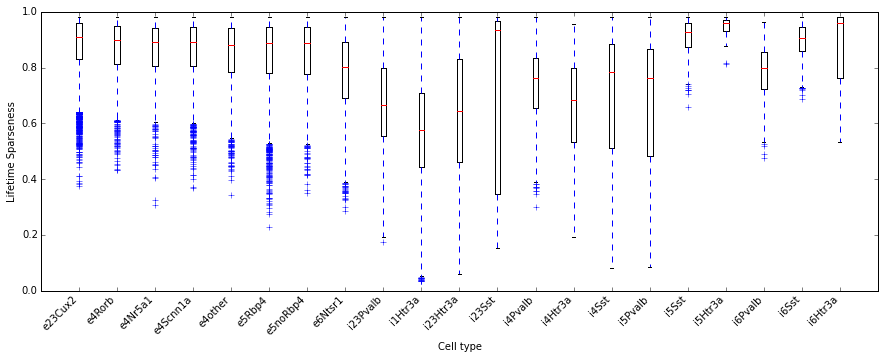

In [10]:
total_spike_count = np.load(save_result_dir+"spike_rates_natural_movie_1.npy")
lt_sprs = get_lifetime_sprs(total_spike_count)

fig = plt.figure(figsize=(15,5))
ax = plt.subplot(111)

for k, pop_name in enumerate(pop_names_bph):
#     print pop_name

    ids_pop = nodes_DF[nodes_DF.pop_name == pop_name].id
    lt_sprs_pop = lt_sprs[ids_pop]
#     print 'total number of neurons: ', lt_sprs_pop.shape[0]
    sprs_loop = lt_sprs_pop[:]
    lt_sparsity = lt_sprs_pop[~np.isnan(sprs_loop)]
    
    np.savez(save_result_dir+'sparsity/lt_sprs_natural_movie_1_'+pop_name+'.npz', lt_sparsity = lt_sparsity)
    ax.boxplot(lt_sparsity, positions = [k+1], patch_artist= True)
plt.xlim([0,22])
plt.xticks(np.arange(1,pop_names_bph.shape[0]+1), pop_names_bph, rotation=45, ha = 'right')
plt.xlabel('Cell type')
plt.ylabel('Lifetime Sparseness')
plt.show()

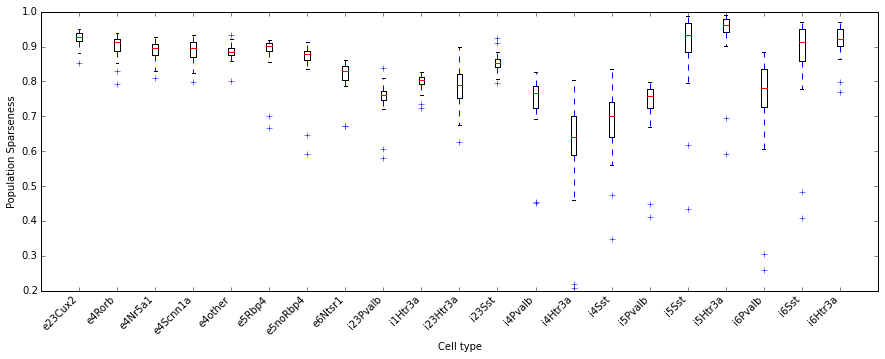

In [11]:
total_spike_count = np.load(save_result_dir+"spike_rates_natural_movie_1.npy")

fig = plt.figure(figsize=(15,5))
ax = plt.subplot(111)

for k, pop_name in enumerate(pop_names_bph):
    ids_pop = nodes_DF[nodes_DF.pop_name == pop_name].id
    lt_sprs_pop = get_pop_sprs(total_spike_count[ids_pop])
    sprs_loop = lt_sprs_pop[:]
    pop_sparsity = lt_sprs_pop[~np.isnan(sprs_loop)]
    
    np.savez(save_result_dir+'sparsity/pop_sprs_natural_movie_1_'+pop_name+'.npz', pop_sparsity = pop_sparsity)
    ax.boxplot(pop_sparsity, positions = [k+1], patch_artist= True)
plt.xlim([0,22])
plt.xticks(np.arange(1,pop_names_bph.shape[0]+1), pop_names_bph, rotation=45, ha = 'right')
plt.xlabel('Cell type')
plt.ylabel('Population Sparseness')
plt.show()

## ephys

In [ ]:
L1_boundary = 28
L23_boundary = 6
L4_boundary = -6
L5_boundary = -28

layer_names = np.array(['e23', 'e4', 'e5' , 'e6', 'i1', 'i23', 'i4', 'i5' , 'i6'])

for mouse in ['392810', '398261', '398263', '404551', '404568', '412792', '412802']:
# for mouse in ['392810']:

    print "MOUSE: " + mouse
    mouse_DF = pd.read_csv('//allen/aibs/mat/yazan/corticalCol/ice/analysis/neuropixels_data/mouse' + mouse + 'drifting_tuning_tf2.0.csv')
    mouse_meta = pd.read_csv('//allen/aibs/mat/yazan/corticalCol/ice/analysis/neuropixels_data/mouse' + mouse + '_cortex_meta.csv')
    mouse_DF['type'] = mouse_meta.type

    dsi = np.array(mouse_DF.ix[mouse_DF.area == 'V1', 'dsi'])
    osi = np.array(mouse_DF.ix[mouse_DF.area == 'V1', 'osi'])

    depth = np.array(mouse_DF.ix[mouse_DF.area == 'V1', 'rel_layer4'])
    blank = np.array(mouse_DF.ix[mouse_DF.area == 'V1', 'blank'])
    FR = np.array(mouse_DF.ix[mouse_DF.area == 'V1', 'FR'])
    neuronType = list(mouse_DF.ix[mouse_DF.area == 'V1', 'type'])
    rs_inds = [i for i, j in enumerate(neuronType) if j == 'rs']
    fs_inds = [i for i, j in enumerate(neuronType) if j == 'fs']

    # Only Htr3a for L1 assumed
    unit_ids_L1 = np.where(depth >= L1_boundary)[0]
    # RS of L2/3
    unit_ids_rs_L23 = np.intersect1d(np.intersect1d(np.where(depth < L1_boundary), np.where(depth >= L23_boundary)), rs_inds)
    # RS of L4
    unit_ids_rs_L4 = np.intersect1d(np.intersect1d(np.where(depth < L23_boundary), np.where(depth >= L4_boundary)), rs_inds)
    # RS of L5
    unit_ids_rs_L5 = np.intersect1d(np.intersect1d(np.where(depth < L4_boundary), np.where(depth >= L5_boundary)), rs_inds)
    # RS for L6
    unit_ids_rs_L6 = np.intersect1d(np.where(depth < L5_boundary), rs_inds)
    # FS of L2/3
    unit_ids_fs_L23 = np.intersect1d(np.intersect1d(np.where(depth < L1_boundary), np.where(depth >= L23_boundary)), fs_inds)
    # FS of L4
    unit_ids_fs_L4 = np.intersect1d(np.intersect1d(np.where(depth < L23_boundary), np.where(depth >= L4_boundary)), fs_inds)
    # FS of L5
    unit_ids_fs_L5 = np.intersect1d(np.intersect1d(np.where(depth < L4_boundary), np.where(depth >= L5_boundary)), fs_inds)
    # FS of L6
    unit_ids_fs_L6 = np.intersect1d(np.where(depth < L5_boundary), fs_inds)
    
    ephys_layer_ids = [unit_ids_rs_L23, unit_ids_rs_L4, unit_ids_rs_L5, unit_ids_rs_L6, unit_ids_L1, unit_ids_fs_L23, 
                      unit_ids_fs_L4, unit_ids_fs_L5, unit_ids_fs_L6]
    

    mouseID='mouse' + mouse

    # path to nwb location
    nwbpath = '/allen/programs/braintv/workgroups/neuralcoding/Ephys_NWB_pilot/NWB_1_1/BOb_1_1/'

    output = '//allen/programs/braintv/workgroups/v1column/rezaa/ephys/'+mouseID
    output_path = output+'/matrix/'

    filename = mouseID+'.spikes.nwb'
    nwb_data = h5py.File(os.path.join(nwbpath,filename),'r')

    condi='cortex'
    #condi='all_units'

    key = 'natural_movie_3_4'
    spike_rate_ephys_1ms = np.rollaxis(np.load(output_path+key+'_'+condi+'.npy'), 2,1)
    spike_rate_ephys_1ms = spike_rate_ephys_1ms[:,40167:42666,:]
    print 'spike rate size: ', spike_rate_ephys_1ms.shape

    win_size = 50
    total_spike_count = change_bin_win(spike_rate_ephys_1ms, win_size)
    print 'binned spike rate size: ', total_spike_count.shape
    
    lt_sprs = get_lifetime_sprs(total_spike_count)
    print lt_sprs.shape

    for k, current_ephys_layer_ids in enumerate(ephys_layer_ids):
        lt_sprs_pop = lt_sprs[current_ephys_layer_ids]
        print 'total number of neurons: ', lt_sprs_pop.shape[0]
        sprs_loop = lt_sprs_pop[:]
        lt_sparsity = lt_sprs_pop[~np.isnan(sprs_loop)] 
        np.savez(save_result_dir+'sparsity/natural_movie/ephys_per_mouse/lt_sprs_natural_movie_3_'+str(layer_names[k])+'_'+mouseID+'.npz', lt_sparsity = lt_sparsity)
    
    

    for k, current_ephys_layer_ids in enumerate(ephys_layer_ids):
        total_spike_count_pop = total_spike_count[current_ephys_layer_ids]
        print 'total number of neurons: ', total_spike_count_pop.shape[0]

        if total_spike_count_pop.shape[0] > 1:
            lt_sprs_pop = get_pop_sprs(total_spike_count_pop)
            sprs_loop = lt_sprs_pop[:]
            pop_sparsity = lt_sprs_pop[~np.isnan(sprs_loop)]
        else: 
            pop_sparsity = np.nan 
        
        np.savez(save_result_dir+'sparsity/natural_movie/ephys_per_mouse/pop_sprs_natural_movie_3_'+str(layer_names[k])+'_'+mouseID+'.npz', pop_sparsity = pop_sparsity)



In [ ]:
layer_names = np.array(['e23', 'e4', 'e5' , 'e6', 'i1', 'i23', 'i4', 'i5' , 'i6'])

for k, layer_name in enumerate(layer_names):
    print layer_name
    pop_sparsity = []
    for mouse in ['392810', '398261', '398263', '404551', '404568', '412792', '412802']:
        mouseID='mouse' + mouse
        sprs_datafile = np.load(save_result_dir+'sparsity/natural_movie/ephys_per_mouse/pop_sprs_natural_movie_3_'+str(layer_name)+'_'+mouseID+'.npz')
        if np.sum(np.isfinite(sprs_datafile['pop_sparsity'])):
            pop_sparsity = np.concatenate((pop_sparsity, sprs_datafile['pop_sparsity']))
#         sig_cors = np.concatenate((sig_cors, corr_datafile['sig_cors']))
#         noise_cors = np.concatenate((noise_cors, corr_datafile['noise_cors']))
    print pop_sparsity
    np.savez(save_result_dir+'sparsity/natural_movie/ephys/pop_sprs_natural_movie_3_'+str(layer_name)+'.npz', pop_sparsity = pop_sparsity)
    

for k, layer_name in enumerate(layer_names):
    print layer_name
    lt_sparsity = []
    for mouse in ['392810', '398261', '398263', '404551', '404568', '412792', '412802']:
        mouseID='mouse' + mouse
        sprs_datafile = np.load(save_result_dir+'sparsity/natural_movie/ephys_per_mouse/lt_sprs_natural_movie_3_'+str(layer_name)+'_'+mouseID+'.npz')
        if np.sum(np.isfinite(sprs_datafile['lt_sparsity'])):
            lt_sparsity = np.concatenate((lt_sparsity, sprs_datafile['lt_sparsity']))
#         sig_cors = np.concatenate((sig_cors, corr_datafile['sig_cors']))
#         noise_cors = np.concatenate((noise_cors, corr_datafile['noise_cors']))
    print lt_sparsity
    np.savez(save_result_dir+'sparsity/natural_movie/ephys/lt_sprs_natural_movie_3_'+str(layer_name)+'.npz', lt_sparsity = lt_sparsity)

# GLIF

In [ ]:
# parameters for calculation of firing rate over step

dir_syn = r'/allen/programs/braintv/workgroups/v1column/binghuangc/network_effect/Column_Simulation/test_gausian_rules_update_syn_tau_shuffle_models/run_production_rule100_tuned/results_rule100_tuned_all/full3_naturalmovie_graycorr_1000Hz_spikes/'

end_time = 3000
start_time = 500
win_size = 50
bin_stride = 50

spike_rates = np.zeros((total_n_neurons, (end_time - start_time)/bin_stride, trials.shape[0]))

for t in trials:
    if stimulusTypeName == "gratings":
        run_name = 'trial_'+str(t)+'/output/spikes.txt'
#                 spikes = np.loadtxt(dir_syn+spikes_file_name, unpack=True)
#                 run_name =  'full3_GScorrected_PScorrected_3.0sec_SF0.04_TF2.0_ori'+str(o)+'.0_c80.0_gs0.5_spikes/trial_'+str(t)+'/output/spikes.txt'
        spike_file = os.path.join(dir_syn, run_name)
        spike_data = pd.read_table(spike_file, sep=" ", names=["time", "cell"])
#                 spike_data = spike_data.ix[spike_data["cell"] < total_n_neurons, :] # don't care about LIFs
        spike_data = spike_data.ix[spike_data["time"] > 500, :] # remove the spont part
        spike_rates[:,:,t] = spike_rates[:,:,t] + bin_resp_spk(spike_data, total_n_neurons, start_time, end_time, win_size, bin_stride) 
    print "Data loaded for trial: ", t
    
np.save(save_result_dir+'spike_rates_natural_movie_1_GLIF.npy', spike_rates)
    